## Import

In [11]:
import os
import pandas as pd

import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import torchvision.models as models # 이미지
from torchvision import transforms
from PIL import Image

from transformers import GPT2Tokenizer, GPT2Model # 텍스트

from tqdm.auto import tqdm

from vit_pytorch import ViT, SimpleViT

## Dataset

In [12]:
class VQADataset(Dataset):
    def __init__(self, df, tokenizer, transform, img_path, is_test=False):
        self.df = df
        self.tokenizer = tokenizer
        self.transform = transform
        self.img_path = img_path
        self.is_test = is_test

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        img_name = os.path.join(self.img_path, row['image_id'] + '.jpg') # 이미지
        image = Image.open(img_name).convert('RGB')
        image = self.transform(image)

        question = row['question'] # 질문
        question = self.tokenizer.encode_plus(
            question,
            truncation=True,
            add_special_tokens=True,
            max_length=32,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
        )

        if not self.is_test:
            answer = row['answer'] # 답변
            answer = self.tokenizer.encode_plus(
                answer,
                max_length=32,
                padding='max_length',
                truncation=True,
                return_tensors='pt')
            return {
                'image': image.squeeze(),
                'question': question['input_ids'].squeeze(),
                'answer': answer['input_ids'].squeeze()
            }
        else:
            return {
                'image': image,
                'question': question['input_ids'].squeeze(),
            }

## Model

In [13]:
class VQAModel(nn.Module):
    def __init__(self, vocab_size):
        super(VQAModel, self).__init__()
        self.vocab_size = vocab_size

        self.vit = SimpleViT(
            image_size = 224,
            patch_size = 32,
            num_classes = 1000,
            dim = 1024,
            depth = 6,
            heads = 16,
            mlp_dim = 2048
        )

        self.gpt2 = GPT2Model.from_pretrained('gpt2')
        self.gpt2.resize_token_embeddings(vocab_size) # 추가한 [PAD] 토큰 반영

        combined_features_size = 1000 + self.gpt2.config.hidden_size # resnet 출력 차원 + gpt2 출력 차원
        self.classifier = nn.Linear(combined_features_size, vocab_size)

    def forward(self, images, question):
        image_features = self.vit(images)
        image_features = image_features.view(image_features.size(0),-1)

        outputs = self.gpt2(question)
        output_features = outputs.last_hidden_state # [batch, sequence, hidden]

        image_features = image_features.unsqueeze(1).expand(-1, output_features.size(1),-1) # [batch, sequence, 1000]
        combined = torch.cat([image_features, output_features], dim=-1) # [batch, sequence, 1000+hidden]
        output = self.classifier(combined) # [batch, vocab_size]
        return output

## DataLoader

In [14]:
# 데이터 불러오기
train_df = pd.read_csv('open/train.csv')
test_df = pd.read_csv('open/test.csv')
sample_submission = pd.read_csv('open/sample_submission.csv')
train_img_path = 'open/image/train'
test_img_path = 'open/image/test'

# dataset & dataloader
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.add_special_tokens({'pad_token': '[PAD]'})
vocab_size = len(tokenizer)

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_dataset = VQADataset(train_df, tokenizer, transform, train_img_path, is_test=False)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

## Train & Inference

In [15]:
# device
import torch

device = torch.device("mps") 
print(f"current device is {device}")

def train(model, loader, optimizer, criterion):
    model.train()
    total_loss = 0

    for data in tqdm(loader, total=len(loader)):
        images = data['image'].to(device)
        question = data['question'].to(device)
        answer = data['answer'].to(device)

        optimizer.zero_grad()
        #여기서 문제 발생
        outputs = model(images, question)

        # output: [batch, sequence, vocab], answer : [batch, sequence]
        loss = criterion(outputs.view(-1, outputs.size(-1)), answer.view(-1))
        total_loss += loss.item()

        loss.backward()
        optimizer.step()

    avg_loss = total_loss / len(loader)
    return avg_loss

current device is mps


In [16]:
def inference(model, loader):
    model.eval()
    preds = []
    with torch.no_grad():
        for data in tqdm(loader, total=len(loader)):
            images = data['image'].to(device)
            question = data['question'].to(device)
            outputs = model(images, question) # [batch, sequence, vocab]
            _, pred = torch.max(outputs, dim=2) # values, indices = _, pred
            preds.extend(pred.cpu().numpy())

    return preds

## Run!

In [17]:
# Model
model = VQAModel(vocab_size).to(device)

# Criterion and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=5e-5)

# Training loop
for epoch in range(1):
    avg_loss = train(model, train_loader, optimizer, criterion)
    print(f"Epoch: {epoch+1}, Loss: {avg_loss:.4f}")

  0%|          | 7/5618 [03:55<52:22:49, 33.61s/it]


KeyboardInterrupt: 

## Post-Processing

In [19]:
# Dataset & DataLoader
test_dataset = VQADataset(test_df, tokenizer, transform, test_img_path, is_test=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# inference
preds = inference(model, test_loader)

no_pad_output = []
for pred in preds:
    output = pred[pred != 50257] # [PAD] token 제외
    no_pad_output.append(tokenizer.decode(output).strip()) # 토큰 id -> 토큰

 57%|█████▋    | 363/633 [07:42<05:43,  1.27s/it]


KeyboardInterrupt: 

## Submission

In [20]:
sample_submission['answer'] = no_pad_output
sample_submission.to_csv('submission.csv', index=False)

NameError: name 'no_pad_output' is not defined

In [ ]:
solution = pd.read_csv('solution.csv')

## INFERENCE - PROMPT

100%|██████████| 1/1 [00:05<00:00,  5.31s/it]

Question:  How many buses are there?
Answer:  2


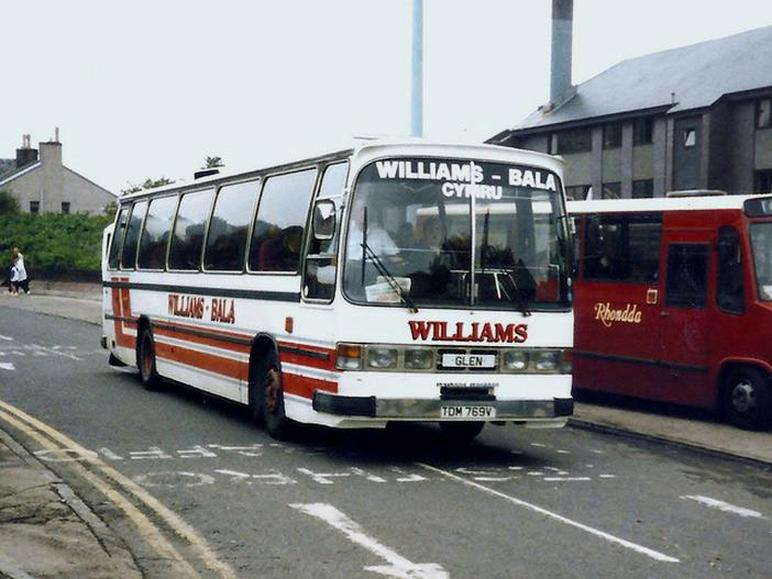

In [30]:
checkpoint = torch.load('vit_gpt_1epoch.pth', map_location=torch.device('mps'))

model = VQAModel(vocab_size).to(device)
model.load_state_dict(torch.load('vit_gpt_1epoch.pth', map_location=torch.device('mps')))
# model = torch.load('vit_gpt_1epoch.pth', map_location=torch.device('mps'))
# model.load_state_dict(torch.load('vit_gpt_1epoch.pth'))

image_path = 'open/image/test'
image = 'test_00021'
question = input()
test_df = pd.DataFrame({"image_id":[image], "question":[question]})

test_dataset = VQADataset(test_df, tokenizer, transform, test_img_path, is_test=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
pred_list = inference(model, test_loader)
for pred in pred_list:
    output = pred[pred != 50257] # [PAD] token 제외

print('Question: ',question)
print('Answer: ', tokenizer.decode(output).strip()) # 토큰 id -> 토큰
Image.open(f'{image_path}/{image}.jpg').convert('RGB')